In [1]:
from config import settings
from hannover_pylon.data import datamodules as dm
from pathlib import Path
from hannover_pylon.modelling.backbone.utils import FromBuffer , CutPSD, NormLayer
import matplotlib.pyplot as plt
from torch import nn 
%load_ext autoreload
%autoreload 2

/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [2]:
import numpy as np
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= [f'psd_level{i+1}_{d}' for i in range(9) for d in ['x','y']]
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))]*len(columns)
query_key = f'''
    SELECT id FROM reshaped
    WHERE date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
'''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='reshaped', columns=columns,transform_func=transform_func, query_key=query_key, batch_size=248, return_dict=True, cached=True,num_workers=16)


In [3]:
data_loader.setup()

In [4]:
for batch in data_loader.train_dataloader():
    break

In [5]:
from hannover_pylon.modelling.backbone import utils as ut
import pytorch_lightning as pl
import torch
class FromOneSensorToAllSensorAutoEncoder(nn.Module):
    def __init__(self, 
                 in_sensor: list = ['psd_level1_x'],
                 out_sensor: list = None,
                 psd_length: int = 1490,
                 shared_layer: list = [512, 128, 64],
                 seperated_layer: list = [32, 8],
                 latent_dim: int = 32):
        super().__init__()
        # Default to reconstructing sensors from level 1 to 9 (x and y)
        if out_sensor is None:
            out_sensor = [f'psd_level{i}_{d}' for i in range(1, 10) for d in ['x', 'y']]
        self.in_sensor = in_sensor
        self.out_sensor = out_sensor
        self.shared_layer = shared_layer
        self.seperated_layer = seperated_layer
        self.latent_dim = latent_dim

        # --- Encoder ---
        # Create an encoder branch for each input sensor.
        self.encoders = nn.ModuleDict()
        for s in in_sensor:
            self.encoders[str(s)] = ut.build_layers(
                hidden_dims=[psd_length] + seperated_layer,
                activation_list=['relu'] * len(seperated_layer)+[None],
                batch_norm=False,
            )
        # Shared encoder: concatenated features from all input sensors.
        self.shared_encoder = ut.build_layers(
            hidden_dims=[len(in_sensor) * seperated_layer[-1]] + shared_layer,
            activation_list='relu',
            batch_norm=False,
        )
        self.latent_layer = nn.Linear(shared_layer[-1], latent_dim)

        # --- Decoder ---
        # Create a decoder branch for each sensor to be reconstructed.
        shared_layer_dec = shared_layer[::-1]
        seperated_layer_dec = seperated_layer[::-1]
        self.shared_decoder = ut.build_layers(
            hidden_dims=[latent_dim] + shared_layer_dec ,
            activation_list='relu',
            batch_norm=False,
        ) 
        
        self.decoders = nn.ModuleDict()
        for s in self.out_sensor:
            self.decoders[str(s)] = ut.build_layers(
                hidden_dims=[shared_layer_dec[-1]] + seperated_layer_dec + [psd_length],
                activation_list=['relu'] * (len(seperated_layer)+1) + ['sigmoid'],
                batch_norm=False,
            )

    def forward(self, x):
        # --- Encoding ---
        encoded_features = []
        for sensor in self.in_sensor:
            if sensor not in x:
                raise ValueError(f"Input does not contain expected sensor '{sensor}'")
            sensor_input = x[sensor]  # shape: (B, psd_length)
            encoded = self.encoders[str(sensor)](sensor_input)  # shape: (B, seperated_layer[-1])
            encoded_features.append(encoded)
        concatenated = torch.cat(encoded_features, dim=1)  # shape: (B, len(in_sensor)*seperated_layer[-1])
        shared_out = self.shared_encoder(concatenated)
        latent = self.latent_layer(shared_out)  # shape: (B, latent_dim)
        
        # --- Decoding ---
        # Pass the latent representation through the shared decoder first.
        shared_decoded = self.shared_decoder(latent)
        
        reconstruction = {}
        for sensor in self.out_sensor:
            # Each sensor-specific decoder then processes the shared decoded features.
            decoded = self.decoders[str(sensor)](shared_decoded)  # shape: (B, psd_length)
            reconstruction[sensor] = decoded

        return {'reconstruction': reconstruction, 'latent': latent}

class AETrainingModule(pl.LightningModule):
    def __init__(self, 
                 in_sensor: list = ['psd_level1_x'],
                 out_sensor: list = None,
                 psd_length: int = 1490,
                 shared_layer: list = [512, 128, 64],
                 seperated_layer: list = [32, 8],
                 latent_dim: int = 32,
                 lr: float = 1e-3):
        super().__init__()
        if out_sensor is None:
            out_sensor = [f'psd_level{i}_{d}' for i in range(1, 10) for d in ['x', 'y']]
        self.save_hyperparameters(ignore=['lr'])
        self.model = FromOneSensorToAllSensorAutoEncoder(
            in_sensor=in_sensor,
            out_sensor=out_sensor,
            psd_length=psd_length,
            shared_layer=shared_layer,
            seperated_layer=seperated_layer,
            latent_dim=latent_dim
        )
        self.loss_fn = nn.MSELoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        output = self(batch)
        reconstructions = output['reconstruction']
        total_loss = 0
        # Compute loss for each sensor’s reconstruction.
        for sensor in self.model.out_sensor:
            if sensor not in batch:
                raise ValueError(f"Batch does not contain target for sensor '{sensor}'")
            total_loss += self.loss_fn(reconstructions[sensor], batch[sensor])
        loss = total_loss / len(self.model.out_sensor)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        output = self(batch)
        reconstructions = output['reconstruction']
        total_loss = 0
        for sensor in self.model.out_sensor:
            total_loss += self.loss_fn(reconstructions[sensor], batch[sensor])
        loss = total_loss / len(self.model.out_sensor)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        output = self(batch)
        reconstructions = output['reconstruction']
        total_loss = 0
        for sensor in self.model.out_sensor:
            total_loss += self.loss_fn(reconstructions[sensor], batch[sensor])
        loss = total_loss / len(self.model.out_sensor)
        self.log("test_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [6]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch

# Instantiate your Lightning module.
model = AETrainingModule(
    in_sensor=['psd_level1_x','psd_level1_y'],
    out_sensor=[f'psd_level{i}_{d}' for i in range(1, 10) for d in ['x', 'y']],
    psd_length=1490,
    shared_layer=[128,64,32],
    seperated_layer=[2048,1024,512],
    latent_dim=4,
    lr=1e-3
)


# Define a model checkpoint callback to save the best models.
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',              # Monitor the validation loss.
    dirpath='checkpoints',           # Directory to save checkpoints.
    filename='autoencoder-{epoch:02d}-{val_loss:.4f}', 
    save_top_k=3,                    # Save the 3 best models.
    mode='min'
)

# Define an early stopping callback (optional).
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=True,
    mode='min'
)

# Create the Trainer instance.
trainer = Trainer(
    max_epochs=150,
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator='gpu'
)

# Start training.
trainer.fit(model,data_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_

DataModule already setup


/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 29/29 [00:03<00:00,  8.39it/s, v_num=171, train_loss_step=0.0136, val_loss=0.0116, train_loss_epoch=0.019]

Metric val_loss improved. New best score: 0.012


Epoch 1: 100%|██████████| 29/29 [00:03<00:00,  7.43it/s, v_num=171, train_loss_step=0.0107, val_loss=0.00921, train_loss_epoch=0.0102]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.009


Epoch 2: 100%|██████████| 29/29 [00:03<00:00,  7.45it/s, v_num=171, train_loss_step=0.00764, val_loss=0.00855, train_loss_epoch=0.00882]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.009


Epoch 3: 100%|██████████| 29/29 [00:04<00:00,  7.18it/s, v_num=171, train_loss_step=0.00913, val_loss=0.00812, train_loss_epoch=0.00829]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  7.13it/s, v_num=171, train_loss_step=0.00923, val_loss=0.00811, train_loss_epoch=0.00801]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 5: 100%|██████████| 29/29 [00:04<00:00,  7.07it/s, v_num=171, train_loss_step=0.00847, val_loss=0.00793, train_loss_epoch=0.00851]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 6: 100%|██████████| 29/29 [00:03<00:00,  7.31it/s, v_num=171, train_loss_step=0.00752, val_loss=0.00784, train_loss_epoch=0.0079] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 7: 100%|██████████| 29/29 [00:03<00:00,  7.52it/s, v_num=171, train_loss_step=0.00989, val_loss=0.00772, train_loss_epoch=0.00773]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 8: 100%|██████████| 29/29 [00:03<00:00,  7.36it/s, v_num=171, train_loss_step=0.00834, val_loss=0.00769, train_loss_epoch=0.00769]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 9: 100%|██████████| 29/29 [00:04<00:00,  7.06it/s, v_num=171, train_loss_step=0.00797, val_loss=0.00765, train_loss_epoch=0.00766]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 10: 100%|██████████| 29/29 [00:04<00:00,  7.20it/s, v_num=171, train_loss_step=0.00713, val_loss=0.00763, train_loss_epoch=0.00762]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 12: 100%|██████████| 29/29 [00:03<00:00,  7.55it/s, v_num=171, train_loss_step=0.00613, val_loss=0.00756, train_loss_epoch=0.00757]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 13: 100%|██████████| 29/29 [00:03<00:00,  7.29it/s, v_num=171, train_loss_step=0.00741, val_loss=0.00753, train_loss_epoch=0.00753]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Epoch 14: 100%|██████████| 29/29 [00:04<00:00,  7.08it/s, v_num=171, train_loss_step=0.00809, val_loss=0.00748, train_loss_epoch=0.00749]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 15: 100%|██████████| 29/29 [00:04<00:00,  7.20it/s, v_num=171, train_loss_step=0.00741, val_loss=0.00745, train_loss_epoch=0.00745]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 16: 100%|██████████| 29/29 [00:04<00:00,  7.02it/s, v_num=171, train_loss_step=0.00733, val_loss=0.0074, train_loss_epoch=0.00741] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 17: 100%|██████████| 29/29 [00:03<00:00,  7.48it/s, v_num=171, train_loss_step=0.00731, val_loss=0.0074, train_loss_epoch=0.00737]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 18: 100%|██████████| 29/29 [00:03<00:00,  7.47it/s, v_num=171, train_loss_step=0.00687, val_loss=0.00728, train_loss_epoch=0.0073] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 19: 100%|██████████| 29/29 [00:03<00:00,  7.27it/s, v_num=171, train_loss_step=0.00588, val_loss=0.00727, train_loss_epoch=0.00727]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 21: 100%|██████████| 29/29 [00:03<00:00,  7.41it/s, v_num=171, train_loss_step=0.00711, val_loss=0.00716, train_loss_epoch=0.00716]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 22: 100%|██████████| 29/29 [00:03<00:00,  7.32it/s, v_num=171, train_loss_step=0.0074, val_loss=0.00715, train_loss_epoch=0.00711] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 24: 100%|██████████| 29/29 [00:04<00:00,  7.17it/s, v_num=171, train_loss_step=0.0068, val_loss=0.00696, train_loss_epoch=0.00718] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 25: 100%|██████████| 29/29 [00:03<00:00,  7.37it/s, v_num=171, train_loss_step=0.00755, val_loss=0.00688, train_loss_epoch=0.00689]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 26: 100%|██████████| 29/29 [00:03<00:00,  7.52it/s, v_num=171, train_loss_step=0.00768, val_loss=0.00681, train_loss_epoch=0.00681]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 27: 100%|██████████| 29/29 [00:03<00:00,  7.34it/s, v_num=171, train_loss_step=0.00674, val_loss=0.00679, train_loss_epoch=0.00678]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 28: 100%|██████████| 29/29 [00:03<00:00,  7.33it/s, v_num=171, train_loss_step=0.0067, val_loss=0.00676, train_loss_epoch=0.00676] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 29: 100%|██████████| 29/29 [00:04<00:00,  6.94it/s, v_num=171, train_loss_step=0.00571, val_loss=0.00669, train_loss_epoch=0.0067] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 30: 100%|██████████| 29/29 [00:03<00:00,  7.29it/s, v_num=171, train_loss_step=0.00609, val_loss=0.00667, train_loss_epoch=0.00666]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 31: 100%|██████████| 29/29 [00:03<00:00,  7.43it/s, v_num=171, train_loss_step=0.0065, val_loss=0.00665, train_loss_epoch=0.00664] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 32: 100%|██████████| 29/29 [00:03<00:00,  7.48it/s, v_num=171, train_loss_step=0.00523, val_loss=0.00663, train_loss_epoch=0.00662]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 33: 100%|██████████| 29/29 [00:03<00:00,  7.37it/s, v_num=171, train_loss_step=0.00619, val_loss=0.00663, train_loss_epoch=0.00661]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 34: 100%|██████████| 29/29 [00:04<00:00,  7.16it/s, v_num=171, train_loss_step=0.00585, val_loss=0.00662, train_loss_epoch=0.0066] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 35: 100%|██████████| 29/29 [00:03<00:00,  7.54it/s, v_num=171, train_loss_step=0.00646, val_loss=0.00658, train_loss_epoch=0.00658]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 36: 100%|██████████| 29/29 [00:03<00:00,  7.59it/s, v_num=171, train_loss_step=0.00458, val_loss=0.00657, train_loss_epoch=0.00655]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 37: 100%|██████████| 29/29 [00:03<00:00,  7.42it/s, v_num=171, train_loss_step=0.00687, val_loss=0.0065, train_loss_epoch=0.00653] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 39: 100%|██████████| 29/29 [00:04<00:00,  7.11it/s, v_num=171, train_loss_step=0.00439, val_loss=0.00647, train_loss_epoch=0.00647]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 41: 100%|██████████| 29/29 [00:03<00:00,  7.67it/s, v_num=171, train_loss_step=0.00549, val_loss=0.00644, train_loss_epoch=0.00644]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 43: 100%|██████████| 29/29 [00:04<00:00,  7.13it/s, v_num=171, train_loss_step=0.00629, val_loss=0.00643, train_loss_epoch=0.00643]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 44: 100%|██████████| 29/29 [00:03<00:00,  7.35it/s, v_num=171, train_loss_step=0.00738, val_loss=0.00641, train_loss_epoch=0.00639]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 46: 100%|██████████| 29/29 [00:04<00:00,  7.17it/s, v_num=171, train_loss_step=0.00545, val_loss=0.00633, train_loss_epoch=0.00634]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 47: 100%|██████████| 29/29 [00:04<00:00,  7.01it/s, v_num=171, train_loss_step=0.00615, val_loss=0.00632, train_loss_epoch=0.00631]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 48: 100%|██████████| 29/29 [00:04<00:00,  7.17it/s, v_num=171, train_loss_step=0.00578, val_loss=0.0063, train_loss_epoch=0.0063]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 50: 100%|██████████| 29/29 [00:04<00:00,  7.19it/s, v_num=171, train_loss_step=0.00666, val_loss=0.00628, train_loss_epoch=0.00628]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 51: 100%|██████████| 29/29 [00:03<00:00,  7.69it/s, v_num=171, train_loss_step=0.00544, val_loss=0.00627, train_loss_epoch=0.00627]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 52: 100%|██████████| 29/29 [00:03<00:00,  7.31it/s, v_num=171, train_loss_step=0.00499, val_loss=0.00623, train_loss_epoch=0.00631]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 53: 100%|██████████| 29/29 [00:03<00:00,  7.99it/s, v_num=171, train_loss_step=0.00611, val_loss=0.0062, train_loss_epoch=0.0062]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 58: 100%|██████████| 29/29 [00:03<00:00,  8.02it/s, v_num=171, train_loss_step=0.00623, val_loss=0.00615, train_loss_epoch=0.00616]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 60: 100%|██████████| 29/29 [00:03<00:00,  8.25it/s, v_num=171, train_loss_step=0.00484, val_loss=0.00613, train_loss_epoch=0.00615]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 61: 100%|██████████| 29/29 [00:03<00:00,  8.12it/s, v_num=171, train_loss_step=0.00531, val_loss=0.00612, train_loss_epoch=0.00612]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 63: 100%|██████████| 29/29 [00:03<00:00,  8.03it/s, v_num=171, train_loss_step=0.00617, val_loss=0.00611, train_loss_epoch=0.00612]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 64: 100%|██████████| 29/29 [00:03<00:00,  8.41it/s, v_num=171, train_loss_step=0.00594, val_loss=0.0061, train_loss_epoch=0.0061]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 67: 100%|██████████| 29/29 [00:03<00:00,  8.11it/s, v_num=171, train_loss_step=0.00549, val_loss=0.0061, train_loss_epoch=0.0061]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 68: 100%|██████████| 29/29 [00:03<00:00,  8.02it/s, v_num=171, train_loss_step=0.00659, val_loss=0.0061, train_loss_epoch=0.00609]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 72: 100%|██████████| 29/29 [00:03<00:00,  8.00it/s, v_num=171, train_loss_step=0.00603, val_loss=0.0061, train_loss_epoch=0.00609] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 73: 100%|██████████| 29/29 [00:03<00:00,  8.07it/s, v_num=171, train_loss_step=0.0059, val_loss=0.0061, train_loss_epoch=0.00608] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 74: 100%|██████████| 29/29 [00:03<00:00,  8.16it/s, v_num=171, train_loss_step=0.00658, val_loss=0.00609, train_loss_epoch=0.00609]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 76: 100%|██████████| 29/29 [00:03<00:00,  8.23it/s, v_num=171, train_loss_step=0.00556, val_loss=0.00609, train_loss_epoch=0.00608]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 79: 100%|██████████| 29/29 [00:03<00:00,  8.14it/s, v_num=171, train_loss_step=0.00571, val_loss=0.00609, train_loss_epoch=0.00608]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 80: 100%|██████████| 29/29 [00:03<00:00,  8.27it/s, v_num=171, train_loss_step=0.00648, val_loss=0.00609, train_loss_epoch=0.00608]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 81: 100%|██████████| 29/29 [00:03<00:00,  8.16it/s, v_num=171, train_loss_step=0.00528, val_loss=0.00609, train_loss_epoch=0.00608]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 84: 100%|██████████| 29/29 [00:03<00:00,  8.23it/s, v_num=171, train_loss_step=0.00629, val_loss=0.00608, train_loss_epoch=0.00607]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 87: 100%|██████████| 29/29 [00:03<00:00,  8.16it/s, v_num=171, train_loss_step=0.00648, val_loss=0.00608, train_loss_epoch=0.00609]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 89: 100%|██████████| 29/29 [00:03<00:00,  8.15it/s, v_num=171, train_loss_step=0.00697, val_loss=0.00607, train_loss_epoch=0.00607]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 92: 100%|██████████| 29/29 [00:03<00:00,  8.26it/s, v_num=171, train_loss_step=0.00582, val_loss=0.00604, train_loss_epoch=0.00611]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 93: 100%|██████████| 29/29 [00:03<00:00,  8.23it/s, v_num=171, train_loss_step=0.00703, val_loss=0.00603, train_loss_epoch=0.00602]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 94: 100%|██████████| 29/29 [00:03<00:00,  8.12it/s, v_num=171, train_loss_step=0.00699, val_loss=0.006, train_loss_epoch=0.006]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 95: 100%|██████████| 29/29 [00:03<00:00,  8.21it/s, v_num=171, train_loss_step=0.00689, val_loss=0.00596, train_loss_epoch=0.00597]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 96: 100%|██████████| 29/29 [00:03<00:00,  8.16it/s, v_num=171, train_loss_step=0.00499, val_loss=0.00586, train_loss_epoch=0.0059] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 97: 100%|██████████| 29/29 [00:03<00:00,  8.08it/s, v_num=171, train_loss_step=0.00487, val_loss=0.0057, train_loss_epoch=0.00576]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 98: 100%|██████████| 29/29 [00:03<00:00,  8.26it/s, v_num=171, train_loss_step=0.00465, val_loss=0.00561, train_loss_epoch=0.00564]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 99: 100%|██████████| 29/29 [00:03<00:00,  8.24it/s, v_num=171, train_loss_step=0.00435, val_loss=0.00554, train_loss_epoch=0.00555]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 100: 100%|██████████| 29/29 [00:03<00:00,  8.08it/s, v_num=171, train_loss_step=0.00636, val_loss=0.0055, train_loss_epoch=0.00552] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 101: 100%|██████████| 29/29 [00:03<00:00,  8.20it/s, v_num=171, train_loss_step=0.00645, val_loss=0.00544, train_loss_epoch=0.00547]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 102: 100%|██████████| 29/29 [00:03<00:00,  8.25it/s, v_num=171, train_loss_step=0.00544, val_loss=0.00542, train_loss_epoch=0.00542]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 103: 100%|██████████| 29/29 [00:03<00:00,  8.27it/s, v_num=171, train_loss_step=0.00524, val_loss=0.00538, train_loss_epoch=0.0054] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 104: 100%|██████████| 29/29 [00:03<00:00,  8.17it/s, v_num=171, train_loss_step=0.00548, val_loss=0.00535, train_loss_epoch=0.00535]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 105: 100%|██████████| 29/29 [00:03<00:00,  8.20it/s, v_num=171, train_loss_step=0.00592, val_loss=0.00533, train_loss_epoch=0.00532]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 106: 100%|██████████| 29/29 [00:03<00:00,  8.05it/s, v_num=171, train_loss_step=0.00703, val_loss=0.00533, train_loss_epoch=0.00531]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 107: 100%|██████████| 29/29 [00:03<00:00,  8.15it/s, v_num=171, train_loss_step=0.00572, val_loss=0.00528, train_loss_epoch=0.00528]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 108: 100%|██████████| 29/29 [00:03<00:00,  8.24it/s, v_num=171, train_loss_step=0.00541, val_loss=0.00524, train_loss_epoch=0.00525]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 109: 100%|██████████| 29/29 [00:03<00:00,  8.20it/s, v_num=171, train_loss_step=0.00533, val_loss=0.00518, train_loss_epoch=0.00521]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 110: 100%|██████████| 29/29 [00:03<00:00,  8.14it/s, v_num=171, train_loss_step=0.00524, val_loss=0.00515, train_loss_epoch=0.00518]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 111: 100%|██████████| 29/29 [00:03<00:00,  8.35it/s, v_num=171, train_loss_step=0.00531, val_loss=0.00511, train_loss_epoch=0.00513]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 112: 100%|██████████| 29/29 [00:03<00:00,  8.11it/s, v_num=171, train_loss_step=0.00465, val_loss=0.00507, train_loss_epoch=0.00508]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 113: 100%|██████████| 29/29 [00:03<00:00,  8.24it/s, v_num=171, train_loss_step=0.00512, val_loss=0.00507, train_loss_epoch=0.00505]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 114: 100%|██████████| 29/29 [00:03<00:00,  8.21it/s, v_num=171, train_loss_step=0.00567, val_loss=0.00502, train_loss_epoch=0.00503]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 115: 100%|██████████| 29/29 [00:03<00:00,  8.62it/s, v_num=171, train_loss_step=0.00396, val_loss=0.00498, train_loss_epoch=0.00498]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 116: 100%|██████████| 29/29 [00:03<00:00,  8.66it/s, v_num=171, train_loss_step=0.00462, val_loss=0.00497, train_loss_epoch=0.00498]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 117: 100%|██████████| 29/29 [00:03<00:00,  8.66it/s, v_num=171, train_loss_step=0.0042, val_loss=0.00492, train_loss_epoch=0.00493] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 118: 100%|██████████| 29/29 [00:03<00:00,  8.60it/s, v_num=171, train_loss_step=0.00569, val_loss=0.00488, train_loss_epoch=0.00489]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 119: 100%|██████████| 29/29 [00:03<00:00,  8.54it/s, v_num=171, train_loss_step=0.00466, val_loss=0.00484, train_loss_epoch=0.00485]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 120: 100%|██████████| 29/29 [00:03<00:00,  8.61it/s, v_num=171, train_loss_step=0.00484, val_loss=0.00481, train_loss_epoch=0.00481]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 121: 100%|██████████| 29/29 [00:03<00:00,  8.55it/s, v_num=171, train_loss_step=0.00541, val_loss=0.00477, train_loss_epoch=0.00477]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 122: 100%|██████████| 29/29 [00:03<00:00,  8.69it/s, v_num=171, train_loss_step=0.00518, val_loss=0.00473, train_loss_epoch=0.00475]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 124: 100%|██████████| 29/29 [00:03<00:00,  8.63it/s, v_num=171, train_loss_step=0.00457, val_loss=0.00469, train_loss_epoch=0.0047] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 125: 100%|██████████| 29/29 [00:03<00:00,  8.62it/s, v_num=171, train_loss_step=0.00405, val_loss=0.00467, train_loss_epoch=0.00467]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 127: 100%|██████████| 29/29 [00:03<00:00,  8.66it/s, v_num=171, train_loss_step=0.004, val_loss=0.00464, train_loss_epoch=0.00464]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 129: 100%|██████████| 29/29 [00:03<00:00,  8.60it/s, v_num=171, train_loss_step=0.00458, val_loss=0.00461, train_loss_epoch=0.00464]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 130: 100%|██████████| 29/29 [00:03<00:00,  8.63it/s, v_num=171, train_loss_step=0.00483, val_loss=0.00459, train_loss_epoch=0.00459]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 131: 100%|██████████| 29/29 [00:03<00:00,  8.61it/s, v_num=171, train_loss_step=0.00503, val_loss=0.00457, train_loss_epoch=0.00457]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 134: 100%|██████████| 29/29 [00:03<00:00,  8.54it/s, v_num=171, train_loss_step=0.00394, val_loss=0.00449, train_loss_epoch=0.00449]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 135: 100%|██████████| 29/29 [00:03<00:00,  8.63it/s, v_num=171, train_loss_step=0.00423, val_loss=0.00446, train_loss_epoch=0.00447]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 136: 100%|██████████| 29/29 [00:03<00:00,  8.45it/s, v_num=171, train_loss_step=0.00396, val_loss=0.00445, train_loss_epoch=0.00445]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 137: 100%|██████████| 29/29 [00:03<00:00,  8.66it/s, v_num=171, train_loss_step=0.00429, val_loss=0.00444, train_loss_epoch=0.00443]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 138: 100%|██████████| 29/29 [00:03<00:00,  8.78it/s, v_num=171, train_loss_step=0.00412, val_loss=0.00442, train_loss_epoch=0.00442]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 139: 100%|██████████| 29/29 [00:03<00:00,  8.66it/s, v_num=171, train_loss_step=0.00424, val_loss=0.00439, train_loss_epoch=0.00443]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 140: 100%|██████████| 29/29 [00:03<00:00,  8.63it/s, v_num=171, train_loss_step=0.00376, val_loss=0.00439, train_loss_epoch=0.00437]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 142: 100%|██████████| 29/29 [00:03<00:00,  8.51it/s, v_num=171, train_loss_step=0.00511, val_loss=0.00437, train_loss_epoch=0.00436]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 143: 100%|██████████| 29/29 [00:03<00:00,  8.57it/s, v_num=171, train_loss_step=0.00426, val_loss=0.00437, train_loss_epoch=0.00435]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 145: 100%|██████████| 29/29 [00:03<00:00,  8.56it/s, v_num=171, train_loss_step=0.00344, val_loss=0.00435, train_loss_epoch=0.00435]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 146: 100%|██████████| 29/29 [00:03<00:00,  8.66it/s, v_num=171, train_loss_step=0.00364, val_loss=0.00432, train_loss_epoch=0.00432]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 147: 100%|██████████| 29/29 [00:03<00:00,  8.59it/s, v_num=171, train_loss_step=0.00453, val_loss=0.0043, train_loss_epoch=0.00432] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 149: 100%|██████████| 29/29 [00:03<00:00,  8.64it/s, v_num=171, train_loss_step=0.00449, val_loss=0.00429, train_loss_epoch=0.00428]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 29/29 [00:04<00:00,  5.82it/s, v_num=171, train_loss_step=0.00449, val_loss=0.00429, train_loss_epoch=0.00428]


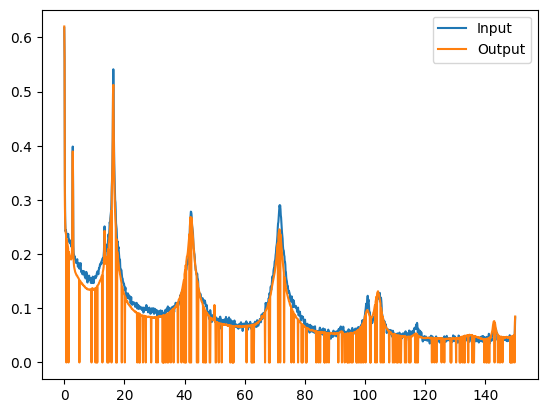

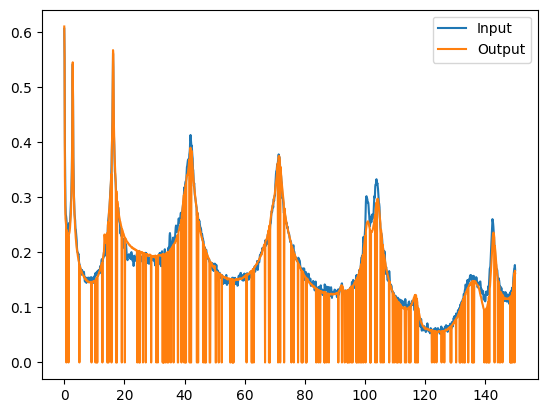

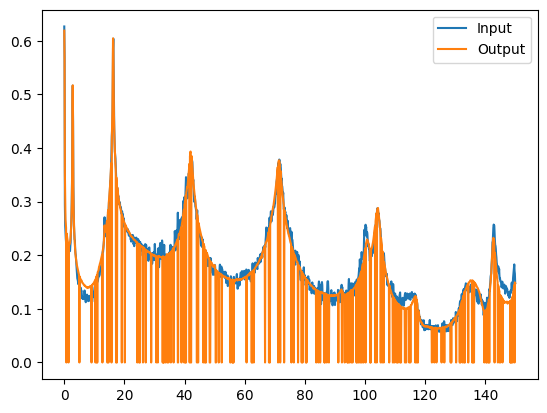

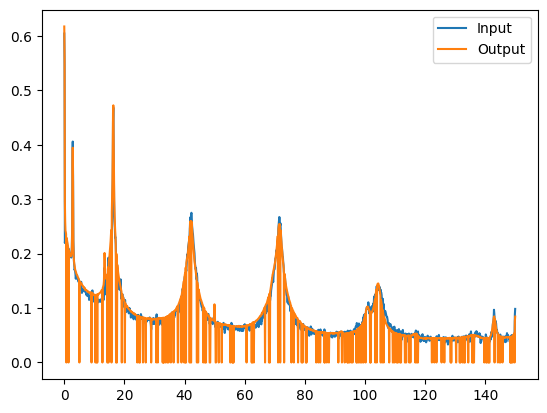

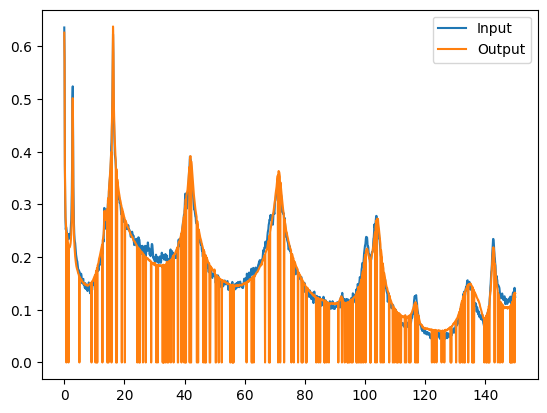

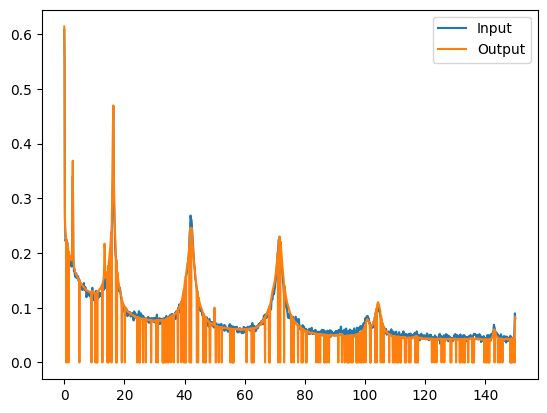

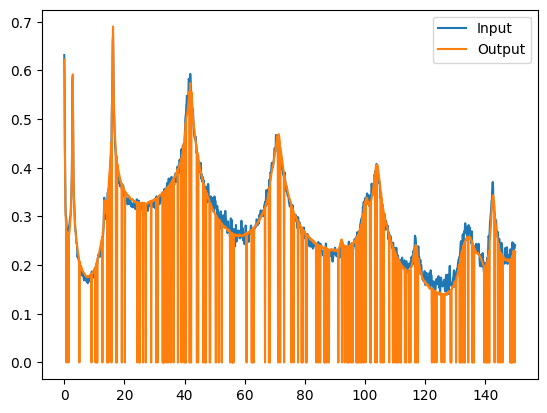

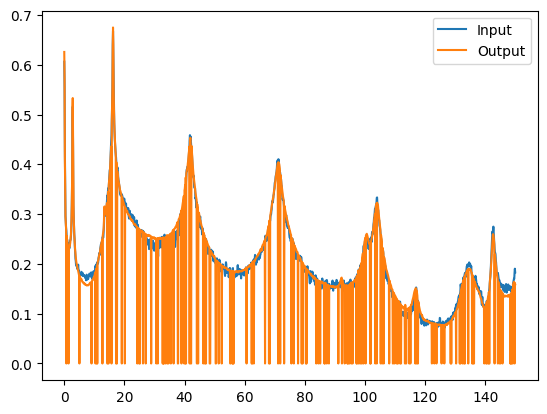

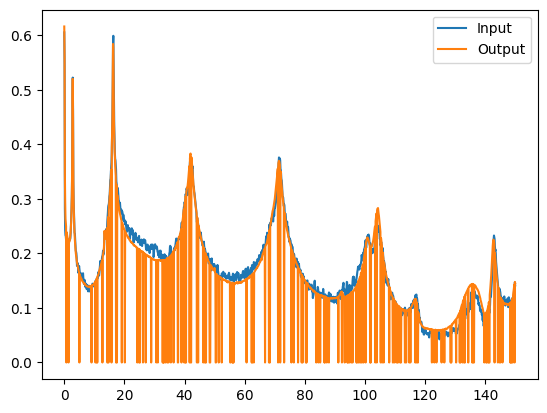

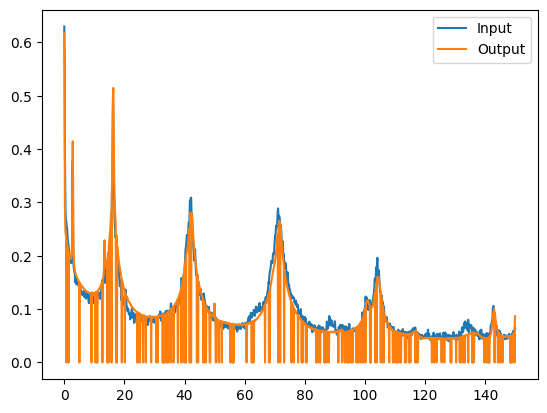

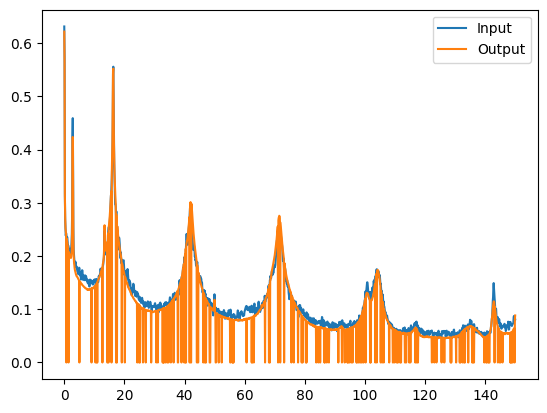

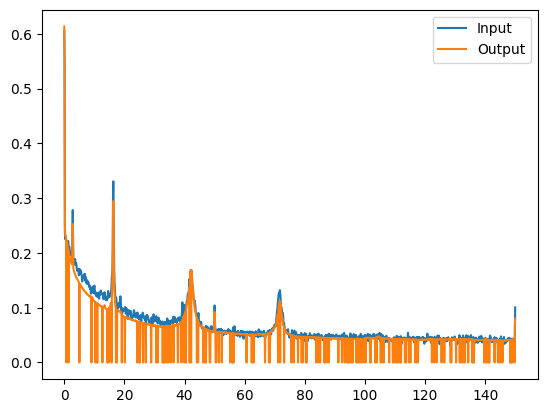

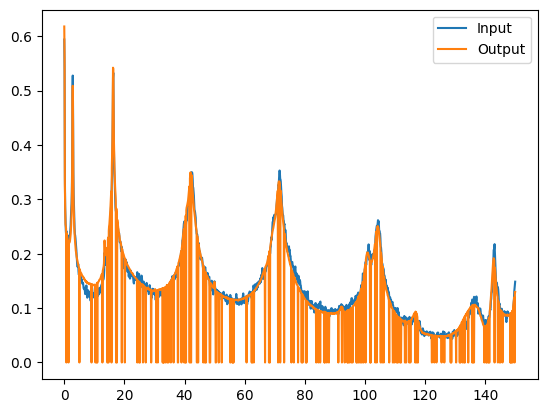

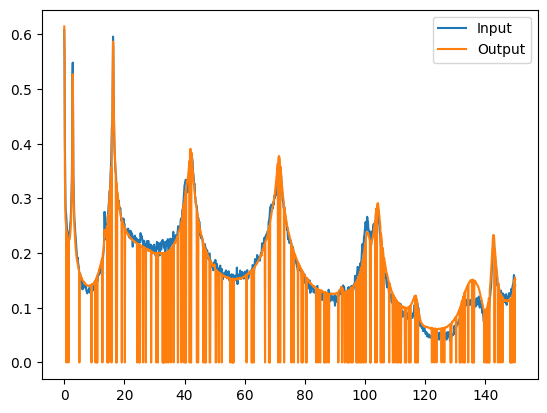

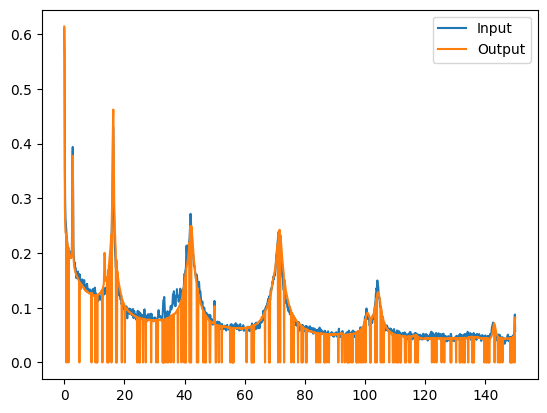

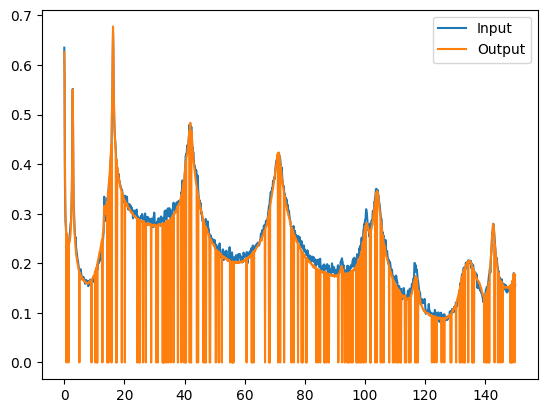

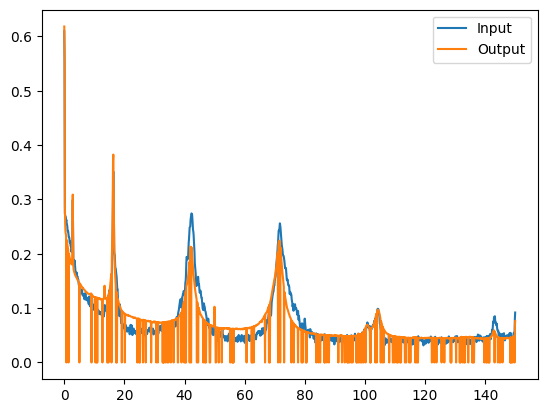

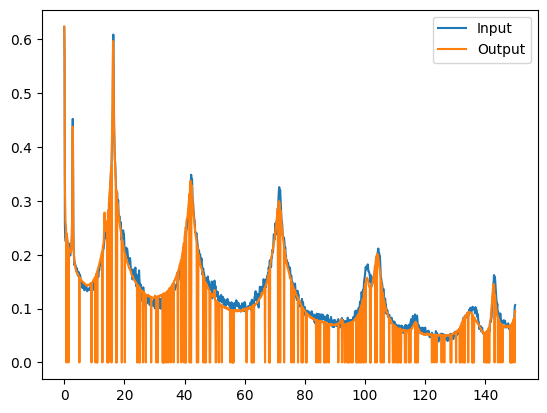

In [7]:
model.eval()
batch = next(iter(data_loader.val_dataloader()))

psd_out = model.model(batch)
psd_in = batch['psd_level8_x']
psd_out = psd_out['reconstruction']['psd_level8_x']

for i in range(18):
    plt.figure()
    plt.plot(freq_axis[0:1490], psd_in[i].detach().numpy(), label='Input')
    plt.plot(freq_axis[0:1490], psd_out[i].detach().numpy(), label='Output')
    plt.legend()
    plt.show()
    plt.close()

In [8]:
import torch
import torch.nn as nn
import torch
from torch import nn
from hannover_pylon.data import datamodules as dm

class Detector(nn.Module):
    def __init__(self, model, monitored_sensors=['psd_level1_x']):

        super().__init__()
        self.model = model
        self.model.eval()  # Set the autoencoder to evaluation mode.
        self.device = next(model.parameters()).device

        # Ensure monitored_sensors is a list
        if isinstance(monitored_sensors, str):
            self.monitored_sensors = [monitored_sensors]
        else:
            self.monitored_sensors = monitored_sensors
        
    def mse(self, x):

        with torch.no_grad():
            output = self.model(x)
        
        errors = {}
        for sensor in self.monitored_sensors:
            if sensor not in x:
                raise ValueError(f"Input does not contain expected sensor '{sensor}'")
            if sensor not in output['reconstruction']:
                raise ValueError(f"Reconstruction does not contain sensor '{sensor}'")
            
            # Retrieve true and reconstructed signals.
            x_true = x[sensor]          # shape: (B, psd_length)
            x_hat = output['reconstruction'][sensor]  # shape: (B, psd_length)
            # Compute squared error.
            error = (x_true - x_hat) ** 2
            # Compute the 90th percentile error along the PSD dimension (assuming dim=1).
            error_quantile = torch.quantile(error, q=0.9, dim=1)
            errors[sensor] = error_quantile
        
        return errors

    def forward(self, x):
        """
        Forward pass returns a dictionary where each key is a monitored sensor and the value is the
        corresponding anomaly score (the 90th percentile of the squared error).
        """
        return self.mse(x)

        

detector =  Detector(model.model, monitored_sensors = [f'psd_level{i}_{d}' for i in range(1,10) for d in ['x','y']]) 

freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= ['date']+[f'psd_level{i+1}_{d}' for i in range(9) for d in ['y','x']]
transform_func = [nn.Identity()]+[nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))]*len(columns)
query_key = f'''
    SELECT id FROM reshaped
'''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='reshaped',columns=columns,transform_func=transform_func, query_key=query_key, batch_size=8196, return_dict=True, cached=False,num_workers=16)
data_loader.setup()

In [ ]:
import pandas as pd

df_list = []

for batch in data_loader.all_dataloader():
    print(batch['date'][0])

    out = detector(batch)
    
    # Create a temporary DataFrame from the 'date' field in the batch.
    # (This assumes that your batch dictionary contains a 'date' key.)
    df_temp = pd.DataFrame({'date': batch['date']})
    
    # For each monitored sensor, add a new column with its corresponding MSE values.
    # Here we append '_mse' to the sensor name as the column name.
    for sensor, mse_tensor in out.items():
        # Convert the tensor to a numpy array (detaching and moving to CPU if needed)
        mse_values = mse_tensor
        df_temp[sensor + '_mse'] = mse_values
    
    # Append the DataFrame for this batch to our list.
    df_list.append(df_temp)

# Concatenate all batch DataFrames into a single DataFrame.
df_results = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the resulting DataFrame.
print(df_results.head())


In [ ]:
import pandas as pd

# Ensure the date column is in datetime format
df_results['date'] = pd.to_datetime(df_results['date'])

# Create a mask for the training period.
# (Assuming settings.state.healthy_train.start and settings.state.healthy_train.end are strings/datetimes.)
train_mask = (df_results['date'] >= pd.to_datetime(settings.state.healthy_train.start)) & \
             (df_results['date'] <= pd.to_datetime(settings.state.healthy_train.end))

# For each column that ends with '_mse', normalize the entire column using the training min and max.
for col in df_results.columns:
    if col.endswith('_mse'):
        train_min = df_results.loc[train_mask, col].min()
        train_max = df_results.loc[train_mask, col].max()
        # Avoid division by zero if train_max equals train_min
        if train_max - train_min != 0:
            df_results[col] = (df_results[col] - train_min) / (train_max - train_min)
        else:
            df_results[col] = 0.0  # or np.nan, depending on what makes sense for your data

# (Optional) Check the first few rows of the normalized columns
print(df_results.head())


                 date  psd_level1_x_mse  psd_level1_y_mse  psd_level2_x_mse  \
0 2020-08-01 00:02:00          0.017173          0.029007          0.012915   
1 2020-08-01 00:12:00          0.015523          0.033583          0.013590   
2 2020-08-01 00:22:00          0.030517          0.015137          0.015179   
3 2020-08-01 00:32:00          0.030647          0.014860          0.016325   
4 2020-08-01 00:42:00          0.095759          0.133754          0.031503   

   psd_level2_y_mse  psd_level3_x_mse  psd_level3_y_mse  psd_level4_x_mse  \
0          0.009183          0.005545          0.015384          0.105676   
1          0.013393          0.006977          0.018068          0.001546   
2          0.034856          0.004748          0.007277          0.008592   
3          0.005535          0.005132          0.007636          0.003804   
4          0.030698          0.019691          0.047192          0.004950   

   psd_level4_y_mse  psd_level5_x_mse  psd_level5_y_mse  psd_l

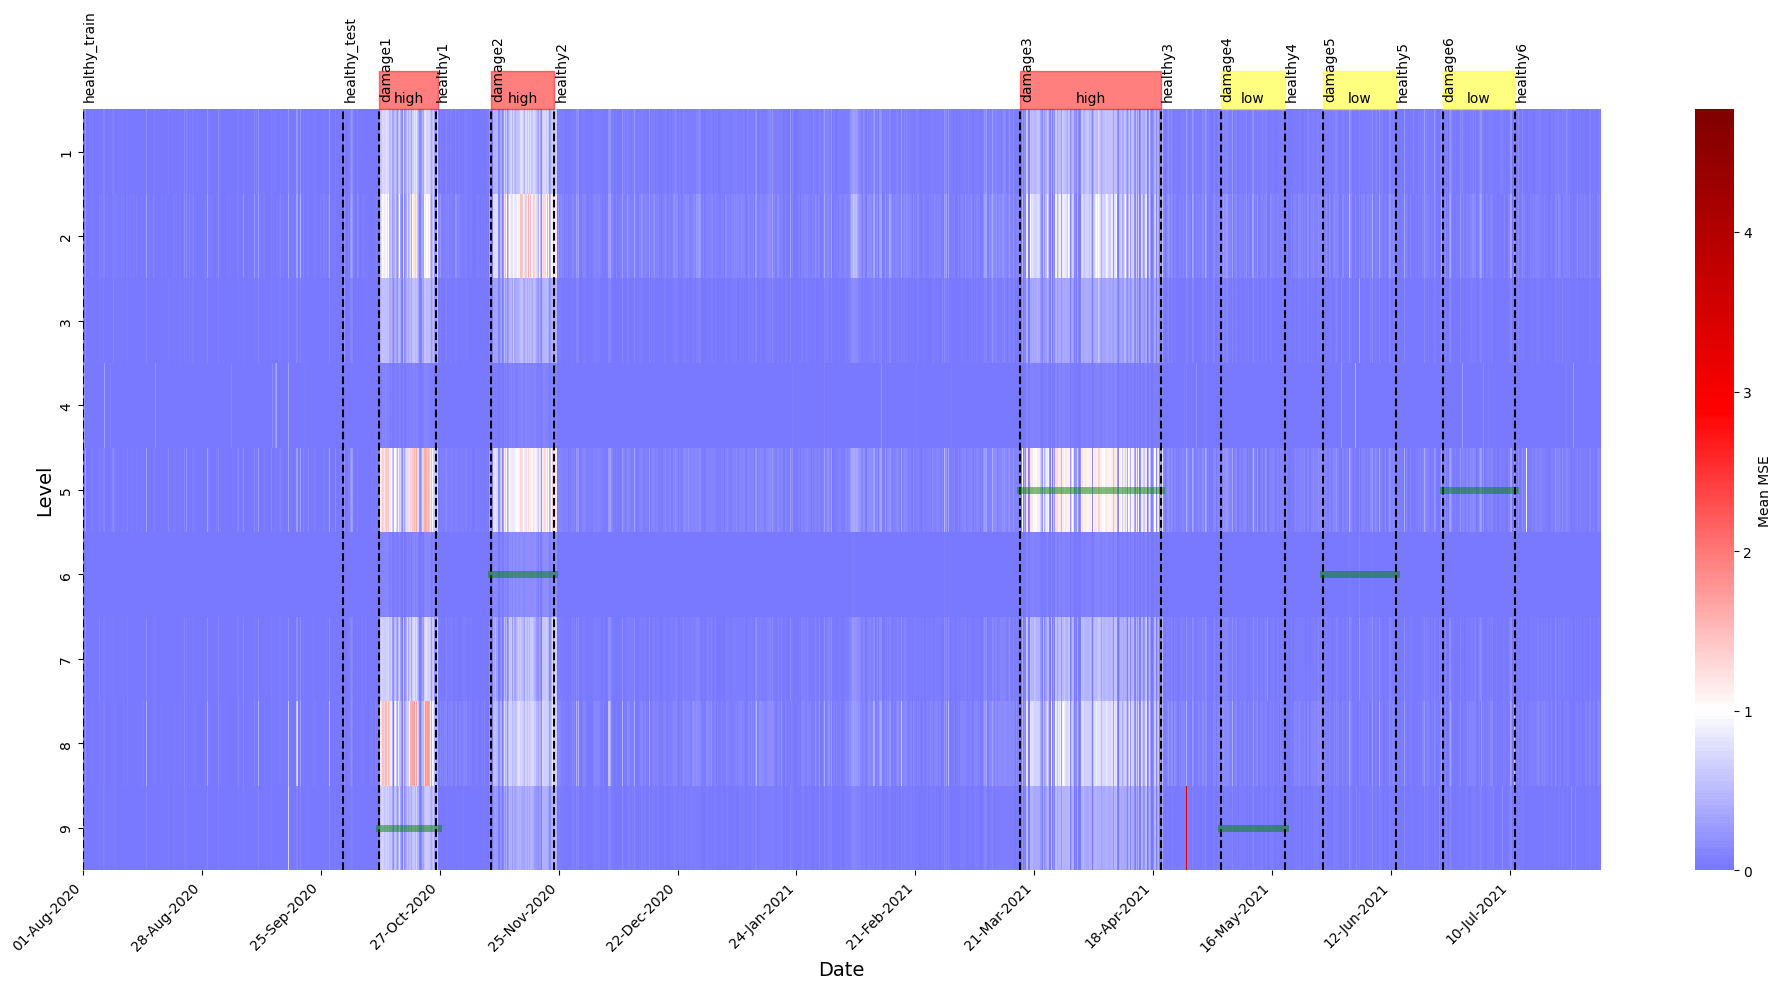

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle

# =============================================================================
# 1. Reshape the DataFrame
# =============================================================================
# Assume df_results is the DataFrame from the detection step. For example, it might look like:
#   date          psd_level1_x_mse   psd_level2_x_mse   psd_level1_y_mse   psd_level2_y_mse   ...
# 2020-01-01 00:00      0.15               0.12              0.20               0.18
# 2020-01-01 01:00      0.16               0.13              0.19               0.17
# ... 

# First, melt the dataframe so that each row corresponds to one sensor measurement.
df_melt = df_results.melt(id_vars=["date"], 
                          var_name="sensor", 
                          value_name="mse")

# Extract sensor level and direction from the sensor column.
# We assume sensor names are of the form "psd_level{num}_{dir}_mse".
df_melt['level'] = df_melt['sensor'].str.extract(r'psd_level(\d+)_')[0].astype(int)
df_melt['direction'] = df_melt['sensor'].str.extract(r'_(x|y)_mse')[0]

# For this control chart we will focus on the "y" direction.
df_melt_y = df_melt[df_melt['direction'] == 'x']

# =============================================================================
# 2. Pivot the DataFrame for a Heatmap
# =============================================================================
# Create a pivot table with sensor level as the index, date as columns, and mean mse as values.
df_pivot = df_melt_y.pivot_table(index='level', columns='date', values='mse', aggfunc='mean')

# Convert the date columns to datetime if not already.
df_pivot.columns = pd.to_datetime(df_pivot.columns)

# =============================================================================
# 3. Create a Custom Date Formatter for the x-axis
# =============================================================================
def create_date_formatter(column_dates):
    """Return a custom formatter function for datetime labels."""
    def custom_date_format(x, pos=None):
        try:
            idx = int(x)
            if 0 <= idx < len(column_dates):
                return column_dates[idx].strftime('%d-%b-%Y')
            return ''
        except Exception:
            return ''
    return FuncFormatter(custom_date_format)

# =============================================================================
# 4. Plot the Control Chart (Heatmap)
# =============================================================================
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.heatmap(
    df_pivot, 
    cmap='seismic',              # Use the 'seismic' colormap to highlight extremes.
    cbar_kws={'label': 'Mean MSE'},  # Label for the color bar.
    ax=ax,
    center=1                  # Set maximum value for the color scale.
)

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Level', fontsize=14)

# Create a list of dates from the pivot table columns (which is a DatetimeIndex).
dates_list = list(df_pivot.columns)
ax.xaxis.set_major_formatter(create_date_formatter(dates_list))
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Limit number of ticks

# Rotate x-axis labels for better readability.
plt.xticks(rotation=45, ha='right')

# =============================================================================
# 5. (Optional) Annotate Events on the Chart
# =============================================================================
# If you have a dictionary "events" with keys for each event, you can annotate the plot.
# For example, events could be structured as:
# events = {
#    "Event1": {"start": "2020-01-10", "end": "2020-01-12", "closest_sensor": 3, "severity": "high"},
#    "Event2": {"start": "2020-02-05", "end": "2020-02-07", "closest_sensor": 2, "severity": "low"}
# }
# Uncomment and adjust the following code if you have such an events dictionary.
events = settings.state.to_dict()
for event_i in events:
    start = pd.to_datetime(events[event_i]['start'])
    end = pd.to_datetime(events[event_i]['end'])
    # Find approximate x-axis indices corresponding to start and end dates.
    idx_start = np.searchsorted(df_pivot.columns, start)
    idx_end = np.searchsorted(df_pivot.columns, end)
    
    # Draw vertical line at the event start.
    ax.axvline(idx_start, color='black', linestyle='--', label=f'{event_i} start')
    ax.text(idx_start, -0.1, f'{event_i}', rotation=90, va='bottom', ha='left')
    
    # Draw horizontal line at the sensor level closest to the event.
    level = events[event_i].get('closest_sensor', None)
    if level is not None:
        ax.axhline(level - 0.5, xmin=idx_start/len(df_pivot.columns), xmax=idx_end/len(df_pivot.columns), 
                color='green', linestyle='-', lw=5, alpha=0.5)
    
    # Draw a rectangle above the plot indicating severity.
    severity = events[event_i].get('severity', None)
    if severity is not None:
        color = 'red' if severity == 'high' else 'yellow'
        box_height = 0.05  # Height of the severity box.
        ax.add_patch(Rectangle(
            (idx_start, 1),       # Start above the plot.
            width=idx_end - idx_start,
            height=box_height,
            color=color, 
            alpha=0.5,
            transform=ax.get_xaxis_transform(),
            clip_on=False
        ))
        ax.text((idx_start + idx_end) / 2, -0.1 + box_height, severity, ha='center', va='bottom', color='black')

# =============================================================================
# 6. Finalize and Show the Plot
# =============================================================================
plt.tight_layout()
plt.show()
